In [1]:
import torch
import torch.nn as nn

In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms, datasets
from torchvision.utils import save_image

In [3]:
import os

In [4]:
#Funkcje pomocnicze
def to_img(x):
    x = 0.5 * x + 0.5
    z = x.clamp(0,1)
    x = x.view(x.size(0),1,28,28)
    return x

In [25]:
img_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=img_transforms,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=img_transforms,
    download=True
)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# data_iter = iter(train_loader)
# images, labels = next(data_iter)

# print(f"Shape of images batch: {images.shape}")
# print(f"Shape of labels batch: {labels.shape}")

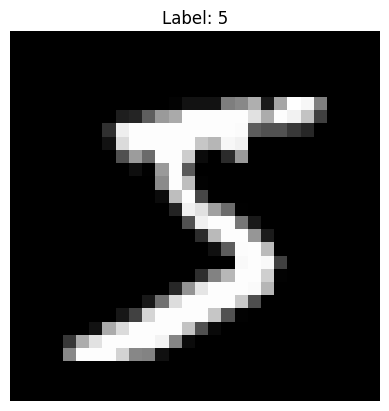

Wymiary obrazka: torch.Size([1, 28, 28])


In [9]:
import matplotlib.pyplot as plt

sample_image, sample_label = train_dataset[0]

plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

print(f"Wymiary obrazka: {sample_image.shape}")

In [10]:
#TODO: Poekperymentuj z różnymi rozmiarami warstw
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "fc"
        os.makedirs(f"./{self.name}_img",exist_ok=True)

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28
                , 128),
            nn.ReLU(True),
            nn.Linear(128,64),
            nn.ReLU(True),
            nn.Linear(64,12),
            nn.ReLU(True),
            nn.Linear(12,3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(True),
            nn.Linear(12,64),
            nn.ReLU(True),
            nn.Linear(64,128),
            nn.ReLU(True),
            nn.Linear(128,28*28),
            #jak normalizujemy na wejściu obrazki to sa od -1 do 1 i tym Tanh zapewniamy, że wyjście też będzie z tego samego przedziału
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [24]:
n_epochs = 30
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = FullyConnectedAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer= torch.optim.Adam(model.parameters(),lr=1e-3)

for epoch in range(n_epochs):
    for data in dataloader:
        images, _ = data
        images = images.view(images.size(0), -1).to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, n_epochs, loss.item()))
    #Zapisz output oraz input na dysk co 10 epok
    if (epoch + 1) % 10 == 0:
        os.makedirs("outputs", exist_ok=True)
        # sample_input = images[0].cpu().view(28, 28).detach().numpy()
        # sample_output = outputs[0].cpu().view(28, 28).detach().numpy()

        # torch.save(images, f"outputs/input_epoch_{epoch+1}.pt")
        # torch.save(outputs, f"outputs/output_epoch_{epoch+1}.pt")
        # print(f"Zapisano input i output dla epoki {epoch+1}.")

        sample_input = images[:8]
        sample_output = outputs[:8]

        sample_input = to_img(sample_input)
        sample_output = to_img(sample_output)

        save_image(sample_input, f"outputs/linear_input_epoch_{epoch+1}.png", nrow=4, normalize=True)
        save_image(sample_output, f"outputs/linear_output_epoch_{epoch+1}.png", nrow=4, normalize=True)
        print(f"Zapisano obrazy wejściowe i wyjściowe dla epoki {epoch+1}.")

epoch [1/30], loss:0.1374
epoch [2/30], loss:0.1574
epoch [3/30], loss:0.1322
epoch [4/30], loss:0.1429
epoch [5/30], loss:0.1265
epoch [6/30], loss:0.1429
epoch [7/30], loss:0.1592
epoch [8/30], loss:0.1337
epoch [9/30], loss:0.1315
epoch [10/30], loss:0.1375
Zapisano obrazy wejściowe i wyjściowe dla epoki 10.
epoch [11/30], loss:0.1248
epoch [12/30], loss:0.1175
epoch [13/30], loss:0.1246
epoch [14/30], loss:0.1618
epoch [15/30], loss:0.1717
epoch [16/30], loss:0.1279
epoch [17/30], loss:0.1076
epoch [18/30], loss:0.1396
epoch [19/30], loss:0.1337
epoch [20/30], loss:0.1447
Zapisano obrazy wejściowe i wyjściowe dla epoki 20.
epoch [21/30], loss:0.1240
epoch [22/30], loss:0.1292
epoch [23/30], loss:0.1004
epoch [24/30], loss:0.1178
epoch [25/30], loss:0.0985
epoch [26/30], loss:0.1320
epoch [27/30], loss:0.1239
epoch [28/30], loss:0.1229
epoch [29/30], loss:0.1241
epoch [30/30], loss:0.1440
Zapisano obrazy wejściowe i wyjściowe dla epoki 30.


In [16]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "conv"
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
n_epochs = 30
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = ConvAutoencoder().to(device)
optimizer= torch.optim.Adam(model.parameters(),lr=1e-3)

for epoch in range(n_epochs):
    for data in dataloader:
        images, _ = data
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, n_epochs, loss.item()))
    if (epoch + 1) % 10 == 0:
        os.makedirs("outputs", exist_ok=True)
        sample_input = images[:8]
        sample_output = outputs[:8]

        save_image(sample_input, f"outputs/input_epoch_{epoch+1}.png", nrow=4, normalize=True)
        save_image(sample_output, f"outputs/output_epoch_{epoch+1}.png", nrow=4, normalize=True)
        print(f"Zapisano obrazy wejściowe i wyjściowe dla epoki {epoch+1}.")

epoch [1/30], loss:0.1602
epoch [2/30], loss:0.1497
epoch [3/30], loss:0.1333
epoch [4/30], loss:0.1229
epoch [5/30], loss:0.1119
epoch [6/30], loss:0.1338
epoch [7/30], loss:0.1108
epoch [8/30], loss:0.1211
epoch [9/30], loss:0.1052
epoch [10/30], loss:0.0999
Zapisano obrazy wejściowe i wyjściowe dla epoki 10.
epoch [11/30], loss:0.1045
epoch [12/30], loss:0.1100
epoch [13/30], loss:0.1035
epoch [14/30], loss:0.0963
epoch [15/30], loss:0.1037
epoch [16/30], loss:0.0882
epoch [17/30], loss:0.1098
epoch [18/30], loss:0.0940
epoch [19/30], loss:0.0996
epoch [20/30], loss:0.0953
Zapisano obrazy wejściowe i wyjściowe dla epoki 20.
epoch [21/30], loss:0.0985
epoch [22/30], loss:0.0964
epoch [23/30], loss:0.0994
epoch [24/30], loss:0.0946
epoch [25/30], loss:0.0945
epoch [26/30], loss:0.0985
epoch [27/30], loss:0.0860
epoch [28/30], loss:0.1024
epoch [29/30], loss:0.0937
epoch [30/30], loss:0.1054
Zapisano obrazy wejściowe i wyjściowe dla epoki 30.


In [29]:
#TODO wykonaj te same czynoości dla wybranego przez siebie zbioru danych

class ConvAutoencoderCifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "conv"
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=3, padding=1),  # b, 16, 11, 11
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=2, padding=1),  # b, 8, 11, 11
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 4, stride=3, padding=1),  # b, 1, 32, 32
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

cifar_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    transform=img_transforms,
    download=True
)

dataloader = DataLoader(cifar_dataset, batch_size=64, shuffle=True)

n_epochs = 30
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = ConvAutoencoderCifar().to(device)
optimizer= torch.optim.Adam(model.parameters(),lr=1e-3)

for epoch in range(n_epochs):
    for data in dataloader:
        images, _ = data
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, n_epochs, loss.item()))
    if (epoch + 1) % 10 == 0:
        os.makedirs("outputs_cifar", exist_ok=True)
        sample_input = images[:8]
        sample_output = outputs[:8]

        save_image(sample_input, f"outputs_cifar/input_epoch_{epoch+1}.png", nrow=4, normalize=True)
        save_image(sample_output, f"outputs_cifar/output_epoch_{epoch+1}.png", nrow=4, normalize=True)
        print(f"Zapisano obrazy wejściowe i wyjściowe dla epoki {epoch+1}.")

Files already downloaded and verified
epoch [1/30], loss:0.1085
epoch [2/30], loss:0.0928
epoch [3/30], loss:0.1000
epoch [4/30], loss:0.0727
epoch [5/30], loss:0.0729
epoch [6/30], loss:0.0608
epoch [7/30], loss:0.0719
epoch [8/30], loss:0.0815
epoch [9/30], loss:0.0811
epoch [10/30], loss:0.0655
Zapisano obrazy wejściowe i wyjściowe dla epoki 10.
epoch [11/30], loss:0.0740
epoch [12/30], loss:0.0693
epoch [13/30], loss:0.0683
epoch [14/30], loss:0.0838
epoch [15/30], loss:0.0491
epoch [16/30], loss:0.0750
epoch [17/30], loss:0.0656
epoch [18/30], loss:0.0800
epoch [19/30], loss:0.0924
epoch [20/30], loss:0.0616
Zapisano obrazy wejściowe i wyjściowe dla epoki 20.
epoch [21/30], loss:0.1008
epoch [22/30], loss:0.0824
epoch [23/30], loss:0.0643
epoch [24/30], loss:0.0721
epoch [25/30], loss:0.0572
epoch [26/30], loss:0.0579
epoch [27/30], loss:0.0699
epoch [28/30], loss:0.0490
epoch [29/30], loss:0.0652
epoch [30/30], loss:0.0768
Zapisano obrazy wejściowe i wyjściowe dla epoki 30.
